In [1]:
import tensorflow as tf
import warnings
import numpy as np
import datetime
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm._tqdm_notebook import tqdm_notebook
import seaborn as sns
import time
import random


Bad key "text.kerning_factor" on line 4 in
C:\Users\SKD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [393]:
tf.random.set_seed(444444)

AttributeError: module 'tensorflow._api.v1.random' has no attribute 'set_seed'

In [2]:
#Build Data suitable to be fed into LSTM
def build_data(mat, y_col_index):
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [3]:
#Build Data suitable to be fed into LSTM
def build_data_multi(mat):
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
    print("length of time-series i/o",x.shape)
    return x

In [4]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.0001,
    "time_steps": 30
}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

In [5]:
#Build Data suitable to be fed into LSTM
def build_y(mat):
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    y = np.zeros((dim_0, TIME_STEPS))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        y[i] = mat[i:TIME_STEPS+i]
    print("length of time-series i/o", y.shape)
    return y

In [6]:
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [7]:
#Import data from Yahoo finance
import pandas_datareader as pdr
from datetime import datetime
startdate = datetime(2015, 7, 18)
enddate = datetime(2020, 7, 17)

aapl = pdr.get_data_yahoo(symbols='AAPL', start = startdate, end = enddate)
msft = pdr.get_data_yahoo(symbols='MSFT', start = startdate, end = enddate)
googl = pdr.get_data_yahoo(symbols='GOOGL', start = startdate, end = enddate)

In [8]:
print(aapl['Adj Close'].isna().sum())
print(msft['Adj Close'].isna().sum())
print(googl['Adj Close'].isna().sum())

0
0
0


In [9]:
#Calculate additional columns required - Returns, tanh transformed returns, absolute values of these returns
aapl['Returns'] = np.nan
aapl['Returns'] = aapl['Adj Close'].pct_change()

#Can also be the below
#for i in range(1,len(aapl)):
#    aapl['Returns'][i] = ((aapl['Adj Close'][i]/aapl['Close'][i -1]) - 1)

aapl['Returns_tan'] = np.nan
for i in range(1,len(aapl)):
    aapl['Returns_tan'][i] = np.tanh(aapl['Returns'][i]/0.03)
    
aapl['Rel_vol'] = np.nan
x = np.repeat(0, TIME_STEPS)
for i in range(len(aapl) - TIME_STEPS):
    x = aapl['Returns'][i:TIME_STEPS+i]
    aapl['Rel_vol'][i+TIME_STEPS] = np.sqrt(np.mean(x**2))
    
# Replace NA values with 0
aapl.fillna(0, inplace=True)

print(aapl.shape)

(1260, 9)


In [10]:
#Calculate additional columns required - Returns, tanh transformed returns, absolute values of these returns
googl['Returns'] = np.nan
googl['Returns'] = googl['Adj Close'].pct_change()

googl['Returns_tan'] = np.nan
for i in range(1,len(googl)):
    googl['Returns_tan'][i] = np.tanh(googl['Returns'][i]/0.03)
    
googl['Rel_vol'] = np.nan
x = np.repeat(0, TIME_STEPS)
for i in range(len(googl) - TIME_STEPS):
    x = googl['Returns'][i:TIME_STEPS+i]
    googl['Rel_vol'][i+TIME_STEPS] = np.sqrt(np.mean(x**2))
    
# Replace NA values with 0
googl.fillna(0, inplace=True)

print(googl.shape)

(1260, 9)


In [11]:
#Calculate additional columns required - Returns, tanh transformed returns, absolute values of these returns
msft['Returns'] = np.nan
msft['Returns'] = msft['Adj Close'].pct_change()

msft['Returns_tan'] = np.nan
for i in range(1,len(msft)):
    msft['Returns_tan'][i] = np.tanh(msft['Returns'][i]/0.03)
    
msft['Rel_vol'] = np.nan
x = np.repeat(0, TIME_STEPS)
for i in range(len(msft) - TIME_STEPS):
    x =msft['Returns'][i:TIME_STEPS+i]
    msft['Rel_vol'][i+TIME_STEPS] = np.sqrt(np.mean(x**2))
    
# Replace NA values with 0
msft.fillna(0, inplace=True)

print(msft.shape)

(1260, 9)


Text(0, 0.5, 'Returns')

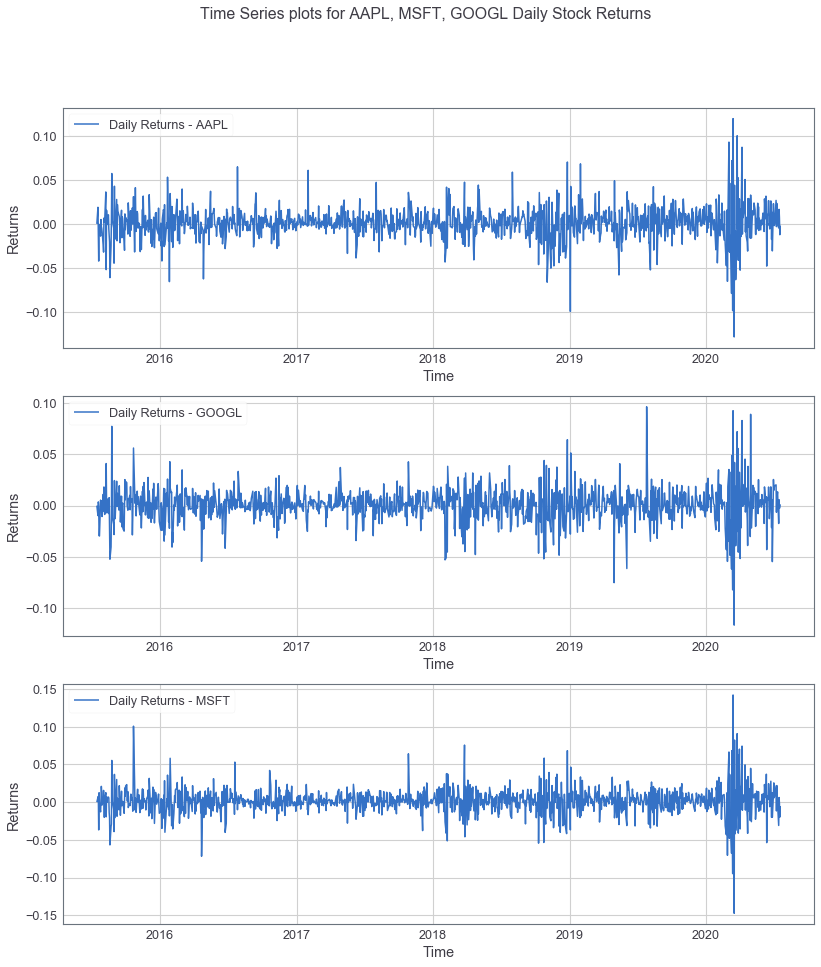

In [12]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

fig = plt.figure(figsize = (12,14))
fig.suptitle('Time Series plots for AAPL, MSFT, GOOGL Daily Stock Returns')
plt.subplot(3, 1, 1)
plt.plot(aapl["Returns"], linewidth = 1.5)
plt.legend(['Daily Returns - AAPL'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Returns")

plt.subplot(3, 1, 2)
plt.plot(googl["Returns"], linewidth = 1.5)
plt.legend(['Daily Returns - GOOGL'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Returns")

plt.subplot(3, 1, 3)
plt.plot(msft["Returns"], linewidth = 1.5)
plt.legend(['Daily Returns - MSFT'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Returns")

In [12]:
from scipy import stats
import statsmodels.api as sm

print (np.mean(aapl['Returns'])) # Mean
print (np.std(aapl['Returns'])) # Standard Deviation
print (stats.skew(aapl['Returns'])) # Skewness
print (stats.kurtosis(aapl['Returns'], fisher = False)) # Kurtosis
print (sm.tsa.stattools.acf(aapl['Returns'], nlags=1))
print (sm.tsa.stattools.acf(np.square(aapl['Returns']),nlags=1))
print (stats.jarque_bera(aapl['Returns']))

0.0010964568724471868
0.01822946104155528
-0.170915110753186
10.53650137114978
[ 1.         -0.11826136]
[1.         0.35973564]
(2988.074292928075, 0.0)


In [13]:
print (np.mean(msft['Returns']))
print (np.std(msft['Returns']))
print (stats.skew(msft['Returns']))
print (stats.kurtosis(msft['Returns'], fisher = False))
print (sm.tsa.stattools.acf(msft['Returns'], nlags=1))
print (sm.tsa.stattools.acf(np.square(msft['Returns']),nlags=1))
print (stats.jarque_bera(msft['Returns']))

0.0013977122577303095
0.017362599458441107
0.1384132843091131
14.67056541631447
[ 1.        -0.2483436]
[1.         0.55910191]
(7154.633329492336, 0.0)


In [14]:
print (np.mean(googl['Returns']))
print (np.std(googl['Returns']))
print (stats.skew(googl['Returns']))
print (stats.kurtosis(googl['Returns'], fisher = False))
print (sm.tsa.stattools.acf(googl['Returns'], nlags=1))
print (sm.tsa.stattools.acf(np.square(googl['Returns']),nlags=1))
print (stats.jarque_bera(googl['Returns']))

0.0007508749728195543
0.016505540635783054
-0.1524451954668799
9.824437237232752
[ 1.         -0.11502496]
[1.       0.299927]
(2449.959842159169, 0.0)


Text(0.51, 0.32, 'MSFT')

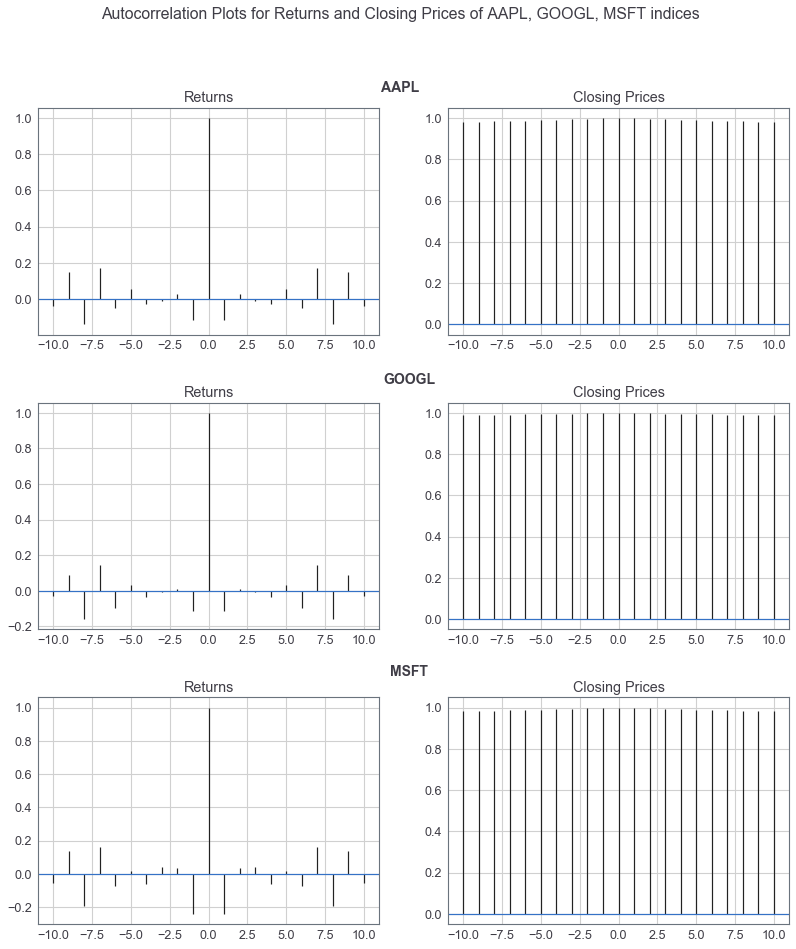

In [16]:
# Plotting the Autocorreleation plot.
fig_acorr = plt.figure(figsize = (12,14))
fig_acorr.suptitle('Autocorrelation Plots for Returns and Closing Prices of AAPL, GOOGL, MSFT indices')
plt.subplots_adjust(hspace=0.3)
plt.subplot(3, 2, 1)
plt.acorr(aapl['Returns'], maxlags = 10)
plt.title("Returns")
plt.subplot(3, 2, 2)
plt.acorr(aapl['Close'], maxlags = 10) 
plt.title("Closing Prices")
plt.subplot(3, 2, 3)
plt.acorr(googl['Returns'], maxlags = 10)  
plt.title("Returns")
plt.subplot(3, 2, 4)
plt.acorr(googl['Close'], maxlags = 10) 
plt.title("Closing Prices")
plt.subplot(3, 2, 5)
plt.acorr(msft['Returns'], maxlags = 10) 
plt.title("Returns")
plt.subplot(3, 2, 6)
plt.acorr(msft['Close'], maxlags = 10) 
plt.title("Closing Prices")


plt.figtext(0.5, 0.9, 'AAPL', fontweight = 800, fontsize = 14, ha='center', va='center')
plt.figtext(0.51, 0.61, 'GOOGL', fontweight = 800, fontsize = 14, ha='center', va='center')
plt.figtext(0.51, 0.32, 'MSFT', fontweight = 800, fontsize = 14, ha='center', va='center')


Text(0, 0.5, 'Returns')

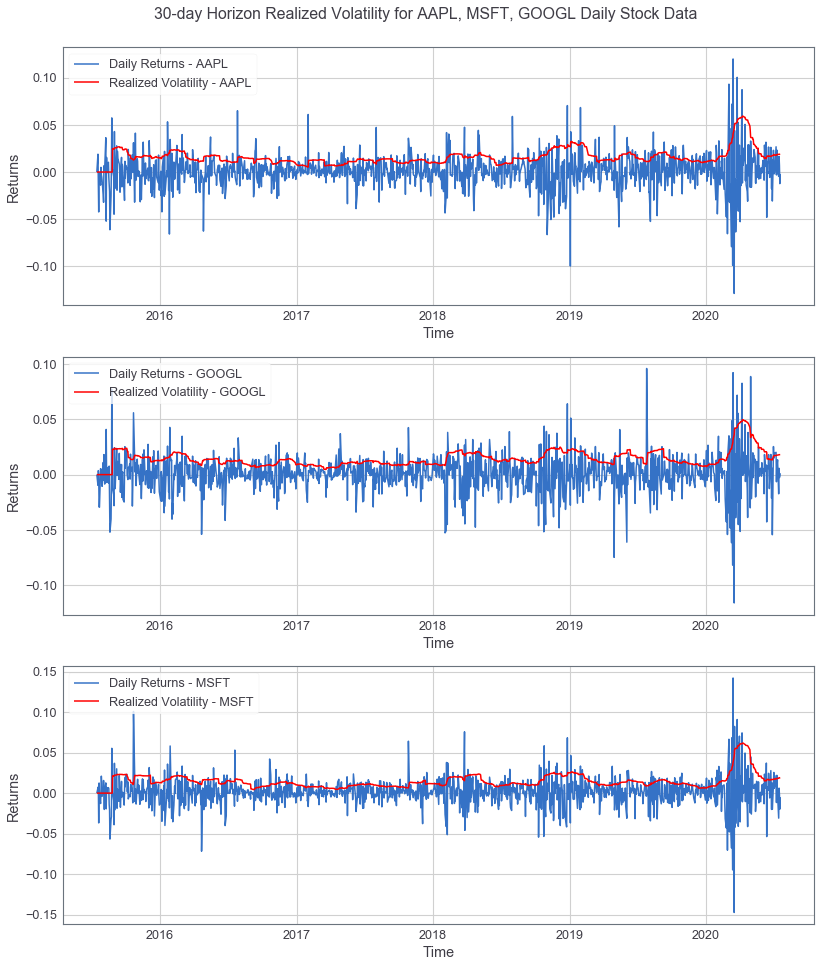

In [18]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

fig = plt.figure(figsize = (12,14))
fig.suptitle('30-day Horizon Realized Volatility for AAPL, MSFT, GOOGL Daily Stock Data')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.subplot(3, 1, 1)
plt.plot(aapl["Returns"], linewidth = 1.5)
plt.plot(aapl["Rel_vol"], linewidth = 1.5, color = 'red')
plt.legend(['Daily Returns - AAPL', 'Realized Volatility - AAPL'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Returns")

plt.subplot(3, 1, 2)
plt.plot(googl["Returns"], linewidth = 1.5)
plt.plot(googl["Rel_vol"], linewidth = 1.5, color = 'red')
plt.legend(['Daily Returns - GOOGL', 'Realized Volatility - GOOGL'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Returns")

plt.subplot(3, 1, 3)
plt.plot(msft["Returns"], linewidth = 1.5)
plt.plot(msft["Rel_vol"], linewidth = 1.5, color = 'red')
plt.legend(['Daily Returns - MSFT', 'Realized Volatility - MSFT'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Returns")

In [15]:
data = pd.concat([aapl, googl, msft]).reset_index(drop = True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   High         3780 non-null   float64
 1   Low          3780 non-null   float64
 2   Open         3780 non-null   float64
 3   Close        3780 non-null   float64
 4   Volume       3780 non-null   float64
 5   Adj Close    3780 non-null   float64
 6   Returns      3780 non-null   float64
 7   Returns_tan  3780 non-null   float64
 8   Rel_vol      3780 non-null   float64
dtypes: float64(9)
memory usage: 265.9 KB


In [17]:
df_train_aapl, df_test_aapl = train_test_split(aapl, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train_aapl), len(df_test_aapl))

Train and Test size 1008 252


In [18]:
df_train_googl, df_test_googl = train_test_split(googl, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train_googl), len(df_test_googl))

Train and Test size 1008 252


In [19]:
df_train_msft, df_test_msft = train_test_split(msft, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train_msft), len(df_test_msft))

Train and Test size 1008 252


In [20]:
pred_index = aapl.index[30: ]

In [21]:
train_cols = ["Returns"]
x_train_aapl = df_train_aapl.loc[:,train_cols].values
x_test_aapl = df_test_aapl.loc[:,train_cols].values
print(x_train_aapl.shape)
print(x_test_aapl.shape)

(1008, 1)
(252, 1)


In [22]:
x_train_googl = df_train_googl.loc[:,train_cols].values
x_test_googl = df_test_googl.loc[:,train_cols].values
print(x_train_googl.shape)
print(x_test_googl.shape)

(1008, 1)
(252, 1)


In [23]:
x_train_msft = df_train_msft.loc[:,train_cols].values
x_test_msft = df_test_msft.loc[:,train_cols].values
print(x_train_msft.shape)
print(x_test_msft.shape)

(1008, 1)
(252, 1)


In [24]:
################# For TRAINING with actual data ##################
x_t_aapl_multi = build_data_multi(x_train_aapl)
x_t_aapl_multi = x_t_aapl_multi[:-30, :]

y_cols = ['Rel_vol']
y_train_aapl_multi = df_train_aapl.loc[ : , y_cols].values
y_test_aapl_multi = df_test_aapl.loc[ : , y_cols].values
y_t_aapl_multi = build_y(y_train_aapl_multi.flatten()[30: ])
print("X_t y_t size",x_t_aapl_multi.shape, y_t_aapl_multi.shape)

dim_0 978



length of time-series i/o (978, 30, 1)
dim_0 948



length of time-series i/o (948, 30)
X_t y_t size (948, 30, 1) (948, 30)


In [25]:
x_t_googl_multi = build_data_multi(x_train_googl)
x_t_googl_multi = x_t_googl_multi[:-30, :]

y_train_googl_multi = df_train_googl.loc[ : , y_cols].values
y_test_googl_multi = df_test_googl.loc[ : , y_cols].values
y_t_googl_multi = build_y(y_train_googl_multi.flatten()[30: ])
print("X_t y_t size",x_t_googl_multi.shape, y_t_googl_multi.shape)

dim_0 978



length of time-series i/o (978, 30, 1)
dim_0 948



length of time-series i/o (948, 30)
X_t y_t size (948, 30, 1) (948, 30)


In [26]:
x_t_msft_multi = build_data_multi(x_train_msft)
x_t_msft_multi = x_t_msft_multi[:-30, :]

y_train_msft_multi = df_train_msft.loc[ : , y_cols].values
y_test_msft_multi = df_test_msft.loc[ : , y_cols].values
y_t_msft_multi = build_y(y_train_msft_multi.flatten()[30: ])
print("X_t y_t size",x_t_msft_multi.shape, y_t_msft_multi.shape)

dim_0 978



length of time-series i/o (978, 30, 1)
dim_0 948



length of time-series i/o (948, 30)
X_t y_t size (948, 30, 1) (948, 30)


In [27]:
################# For TESTING and VALIDATION ################## WO SCALE
x_temp_aapl_multi = build_data_multi(x_test_aapl)
x_temp_aapl_multi = x_temp_aapl_multi[:-30, :]
y_temp_aapl_multi = build_y(y_test_aapl_multi.flatten()[30: ])
print("X_temp y_temp size", x_temp_aapl_multi.shape, y_temp_aapl_multi.shape)

dim_0 222



length of time-series i/o (222, 30, 1)
dim_0 192



length of time-series i/o (192, 30)
X_temp y_temp size (192, 30, 1) (192, 30)


In [28]:
x_temp_googl_multi = build_data_multi(x_test_googl)
x_temp_googl_multi = x_temp_googl_multi[:-30, :]
y_temp_googl_multi = build_y(y_test_googl_multi.flatten()[30: ])
print("X_temp y_temp size", x_temp_googl_multi.shape, y_temp_googl_multi.shape)

dim_0 222



length of time-series i/o (222, 30, 1)
dim_0 192



length of time-series i/o (192, 30)
X_temp y_temp size (192, 30, 1) (192, 30)


In [29]:
x_temp_msft_multi = build_data_multi(x_test_msft)
x_temp_msft_multi = x_temp_msft_multi[:-30, :]
y_temp_msft_multi = build_y(y_test_msft_multi.flatten()[30: ])
print("X_temp y_temp size", x_temp_msft_multi.shape, y_temp_msft_multi.shape)

dim_0 222



length of time-series i/o (222, 30, 1)
dim_0 192



length of time-series i/o (192, 30)
X_temp y_temp size (192, 30, 1) (192, 30)


In [30]:
x_train_multi = np.append(x_t_aapl_multi, x_t_googl_multi, axis = 0)
x_train_multi = np.append(x_train_multi, x_t_msft_multi, axis = 0)
print(x_train_multi.shape)

(2844, 30, 1)


In [31]:
y_train_multi = np.append(y_t_aapl_multi, y_t_googl_multi, axis = 0)
y_train_multi = np.append(y_train_multi, y_t_msft_multi, axis = 0)
print(y_train_multi.shape)

(2844, 30)


In [32]:
x_temp_multi = np.append(x_temp_aapl_multi, x_temp_googl_multi, axis = 0)
x_temp_multi = np.append(x_temp_multi, x_temp_msft_multi, axis = 0)
print(x_temp_multi.shape)

(576, 30, 1)


In [33]:
y_temp_multi = np.append(y_temp_aapl_multi, y_temp_googl_multi, axis = 0)
y_temp_multi = np.append(y_temp_multi, y_temp_msft_multi, axis = 0)
print(y_temp_multi.shape)

(576, 30)


In [34]:
x_val_multi, x_test_t_multi = np.split(trim_dataset(x_temp_multi, BATCH_SIZE),2)
y_val_multi, y_test_t_multi = np.split(trim_dataset(y_temp_multi, BATCH_SIZE),2)

In [35]:
x_train_multi = trim_dataset(x_train_multi, BATCH_SIZE)
y_train_multi = trim_dataset(y_train_multi, BATCH_SIZE)
x_temp_multi = trim_dataset(x_temp_multi, BATCH_SIZE)
y_temp_multi= trim_dataset(y_temp_multi, BATCH_SIZE)
x_val_multi = trim_dataset(x_val_multi, BATCH_SIZE)
y_val_multi= trim_dataset(y_val_multi, BATCH_SIZE)
print("X_temp y_temp size", x_temp_multi.shape, y_temp_multi.shape)
print(x_val_multi.shape, y_val_multi.shape)
print(x_train_multi.shape, y_train_multi.shape)

X_temp y_temp size (560, 30, 1) (560, 30)
(280, 30, 1) (280, 30)
(2840, 30, 1) (2840, 30)


In [36]:
################# For TRAINING with actual data ##################
x_t_aapl, y_t_aapl = build_data(x_train_aapl, 0)
y_t_aapl = aapl['Rel_vol'][TIME_STEPS : len(df_train_aapl)]
y_t_aapl = pd.Series(y_t_aapl)
y_t_aapl.index = pred_index[0: len(y_t_aapl)]
print("X_t y_t size",x_t_aapl.shape, y_t_aapl.shape)

dim_0 978



length of time-series i/o (978, 30, 1) (978,)
X_t y_t size (978, 30, 1) (978,)


In [37]:
################# For TRAINING with actual data ##################
x_t_googl, y_t_googl = build_data(x_train_googl, 0)
y_t_googl = googl['Rel_vol'][TIME_STEPS : len(df_train_googl)]
y_t_googl = pd.Series(y_t_googl)
y_t_googl.index = pred_index[0: len(y_t_googl)]
print("X_t y_t size",x_t_googl.shape, y_t_googl.shape)

dim_0 978



length of time-series i/o (978, 30, 1) (978,)
X_t y_t size (978, 30, 1) (978,)


In [38]:
################# For TRAINING with actual data ##################
x_t_msft, y_t_msft = build_data(x_train_msft, 0)
y_t_msft = msft['Rel_vol'][TIME_STEPS : len(df_train_msft)]
y_t_msft = pd.Series(y_t_msft)
y_t_msft.index = pred_index[0: len(y_t_msft)]
print("X_t y_t size",x_t_msft.shape, y_t_msft.shape)

dim_0 978



length of time-series i/o (978, 30, 1) (978,)
X_t y_t size (978, 30, 1) (978,)


In [39]:
################# For TESTING and VALIDATION ################## WO SCALE
x_temp_aapl, y_temp_aapl = build_data(x_test_aapl, 0)
x_temp_aapl = np.asmatrix(x_temp_aapl)
y_temp_aapl = aapl['Rel_vol'][TIME_STEPS + len(df_train_aapl) : ]
print("X_temp y_temp size", x_temp_aapl.shape, y_temp_aapl.shape)
y_temp_aapl = pd.Series(y_temp_aapl)
y_temp_aapl.index = pred_index[x_train_aapl.shape[0]: ]

dim_0 222



length of time-series i/o (222, 30, 1) (222,)
X_temp y_temp size (222, 30) (222,)


In [40]:
################# For TESTING and VALIDATION ################## WO SCALE
x_temp_googl, y_temp_googl = build_data(x_test_googl, 0)
x_temp_googl = np.asmatrix(x_temp_googl)
y_temp_googl = googl['Rel_vol'][TIME_STEPS + len(df_train_googl) : ]
print("X_temp y_temp size", x_temp_googl.shape, y_temp_googl.shape)
y_temp_googl = pd.Series(y_temp_googl)
y_temp_googl.index = pred_index[x_train_googl.shape[0]: ]

dim_0 222



length of time-series i/o (222, 30, 1) (222,)
X_temp y_temp size (222, 30) (222,)


In [41]:
################# For TESTING and VALIDATION ################## WO SCALE
x_temp_msft, y_temp_msft = build_data(x_test_msft, 0)
x_temp_msft = np.asmatrix(x_temp_msft)
y_temp_msft = msft['Rel_vol'][TIME_STEPS + len(df_train_msft) : ]
print("X_temp y_temp size", x_temp_msft.shape, y_temp_msft.shape)
y_temp_msft = pd.Series(y_temp_msft)
y_temp_msft.index = pred_index[x_train_msft.shape[0]: ]

dim_0 222



length of time-series i/o (222, 30, 1) (222,)
X_temp y_temp size (222, 30) (222,)


In [42]:
y_t_aapl = y_t_aapl.values
x_t_aapl = x_t_aapl.reshape(x_t_aapl.shape[0], TIME_STEPS)
y_t_aapl = y_t_aapl.reshape(y_t_aapl.shape[0], 1)

y_t_googl = y_t_googl.values
x_t_googl = x_t_googl.reshape(x_t_googl.shape[0], TIME_STEPS)
y_t_googl = y_t_googl.reshape(y_t_googl.shape[0], 1)

y_t_msft = y_t_msft.values
x_t_msft = x_t_msft.reshape(x_t_msft.shape[0], TIME_STEPS)
y_t_msft = y_t_msft.reshape(y_t_msft.shape[0], 1)

print(y_t_aapl.shape)
print(x_t_aapl.shape)

print(y_t_googl.shape)
print(x_t_googl.shape)

print(y_t_msft.shape)
print(x_t_msft.shape)

(978, 1)
(978, 30)
(978, 1)
(978, 30)
(978, 1)
(978, 30)


In [43]:
# Resahpe for LSTM
x_t_aapl_lstm = x_t_aapl.reshape(x_t_aapl.shape[0], x_t_aapl.shape[1], 1)
x_t_aapl_lstm = trim_dataset(x_t_aapl_lstm, BATCH_SIZE)
y_t_aapl_lstm = trim_dataset(y_t_aapl, BATCH_SIZE)

x_t_googl_lstm = x_t_googl.reshape(x_t_googl.shape[0], x_t_googl.shape[1], 1)
x_t_googl_lstm = trim_dataset(x_t_googl_lstm, BATCH_SIZE)
y_t_googl_lstm = trim_dataset(y_t_googl, BATCH_SIZE)

x_t_msft_lstm = x_t_msft.reshape(x_t_msft.shape[0], x_t_msft.shape[1], 1)
x_t_msft_lstm = trim_dataset(x_t_msft_lstm, BATCH_SIZE)
y_t_msft_lstm = trim_dataset(y_t_msft, BATCH_SIZE)

In [44]:
#Do not run this block

x_temp_aapl_lstm, y_temp_aapl_lstm = build_data(x_test_aapl, 0)
y_temp_aapl_lstm = aapl['Rel_vol'][TIME_STEPS + len(df_train_aapl) : ]
x_temp_aapl_lstm = trim_dataset(x_temp_aapl_lstm, 20)
y_temp_aapl_lstm = trim_dataset(y_temp_aapl_lstm, 20)
print("X_temp y_temp size", x_temp_aapl_lstm.shape, y_temp_aapl_lstm.shape)

x_temp_googl_lstm, y_temp_googl_lstm = build_data(x_test_googl, 0)
y_temp_googl_lstm = googl['Rel_vol'][TIME_STEPS + len(df_train_googl) : ]
x_temp_googl_lstm = trim_dataset(x_temp_googl_lstm, 20)
y_temp_googl_lstm = trim_dataset(y_temp_googl_lstm, 20)
print("X_temp y_temp size", x_temp_googl_lstm.shape, y_temp_googl_lstm.shape)

x_temp_msft_lstm, y_temp_msft_lstm = build_data(x_test_msft, 0)
y_temp_msft_lstm = msft['Rel_vol'][TIME_STEPS + len(df_train_msft) : ]
x_temp_msft_lstm = trim_dataset(x_temp_msft_lstm, 20)
y_temp_msft_lstm = trim_dataset(y_temp_msft_lstm, 20)
print("X_temp y_temp size", x_temp_msft_lstm.shape, y_temp_msft_lstm.shape)

dim_0 222



length of time-series i/o (222, 30, 1) (222,)
X_temp y_temp size (220, 30, 1) (220,)
dim_0 222



length of time-series i/o (222, 30, 1) (222,)
X_temp y_temp size (220, 30, 1) (220,)
dim_0 222



length of time-series i/o (222, 30, 1) (222,)
X_temp y_temp size (220, 30, 1) (220,)


In [45]:
x_train = np.append(x_t_aapl, x_t_googl, axis = 0)
x_train = np.append(x_train, x_t_msft, axis = 0)
print(x_train.shape)

(2934, 30)


In [46]:
y_train = np.append(y_t_aapl, y_t_googl, axis = 0)
y_train = np.append(y_train, y_t_msft, axis = 0)
print(y_train.shape)

(2934, 1)


In [47]:
x_temp = np.append(x_temp_aapl, x_temp_googl, axis = 0)
x_temp = np.append(x_temp, x_temp_msft, axis = 0)
print(x_temp.shape)

(666, 30)


In [48]:
y_temp = np.append(y_temp_aapl, y_temp_googl, axis = 0)
y_temp = np.append(y_temp, y_temp_msft, axis = 0)
print(y_temp.shape)

(666,)


In [49]:
x_train_lstm = np.append(x_t_aapl_lstm, x_t_googl_lstm, axis = 0)
x_train_lstm = np.append(x_train_lstm, x_t_msft_lstm, axis = 0)
print(x_train_lstm.shape)

(2880, 30, 1)


In [50]:
y_train_lstm = np.append(y_t_aapl_lstm, y_t_googl_lstm, axis = 0)
y_train_lstm = np.append(y_train_lstm, y_t_msft_lstm, axis = 0)
print(y_train_lstm.shape)

(2880, 1)


In [51]:
y_temp_lstm = np.append(y_temp_aapl_lstm, y_temp_googl_lstm, axis = 0)
y_temp_lstm = np.append(y_temp_lstm, y_temp_msft_lstm, axis = 0)
print(y_temp_lstm.shape)

(660,)


In [52]:
x_temp_lstm = np.append(x_temp_aapl_lstm, x_temp_googl_lstm, axis = 0)
x_temp_lstm = np.append(x_temp_lstm, x_temp_msft_lstm, axis = 0)
print(x_temp_lstm.shape)

(660, 30, 1)


In [53]:
x_val_lstm, x_test_t_lstm = np.split(trim_dataset(x_temp_lstm, BATCH_SIZE),2)
y_val_lstm, y_test_t_lstm = np.split(trim_dataset(y_temp_lstm, BATCH_SIZE),2)

## LINEAR REGRESSION

In [54]:
from sklearn.linear_model import LinearRegression

# Create and train the Linear Regression  Model
lr = LinearRegression()

# Train the model
lr.fit(x_train, y_train)

LinearRegression()

In [55]:
lr_confidence = lr.score(x_temp, y_temp)
lr_confidence

-0.1240882391622915

In [56]:
y_pred_lr = lr.predict(x_temp)
y_pred_lr_aapl = lr.predict(x_temp_aapl)
y_pred_lr_googl = lr.predict(x_temp_googl)
y_pred_lr_msft = lr.predict(x_temp_msft)

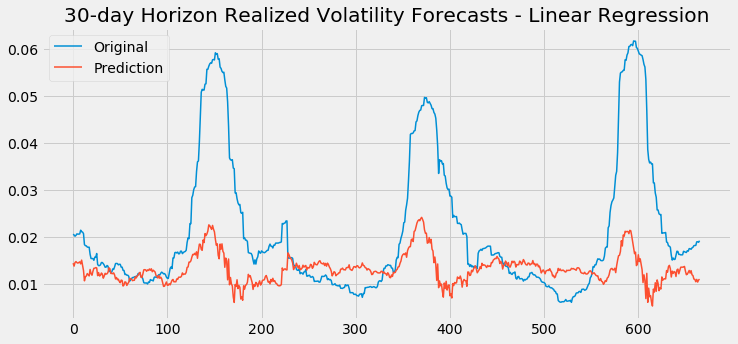

In [57]:
plt.figure(figsize=(11,5))
plt.plot(y_temp, linewidth = 1.5)
plt.plot(y_pred_lr, linewidth = 1.5)
plt.title('30-day Horizon Realized Volatility Forecasts - Linear Regression')
plt.legend(['Original', 'Prediction'], loc='upper left')

In [58]:
y_pred_lr_aapl = pd.Series(y_pred_lr_aapl.flatten())
y_pred_lr_googl = pd.Series(y_pred_lr_googl.flatten())
y_pred_lr_msft = pd.Series(y_pred_lr_msft.flatten())

y_pred_lr_aapl.index = y_temp_aapl.index
y_pred_lr_googl.index = y_temp_googl.index
y_pred_lr_msft.index = y_temp_msft.index

Text(0, 0.5, 'Realized Volatility')

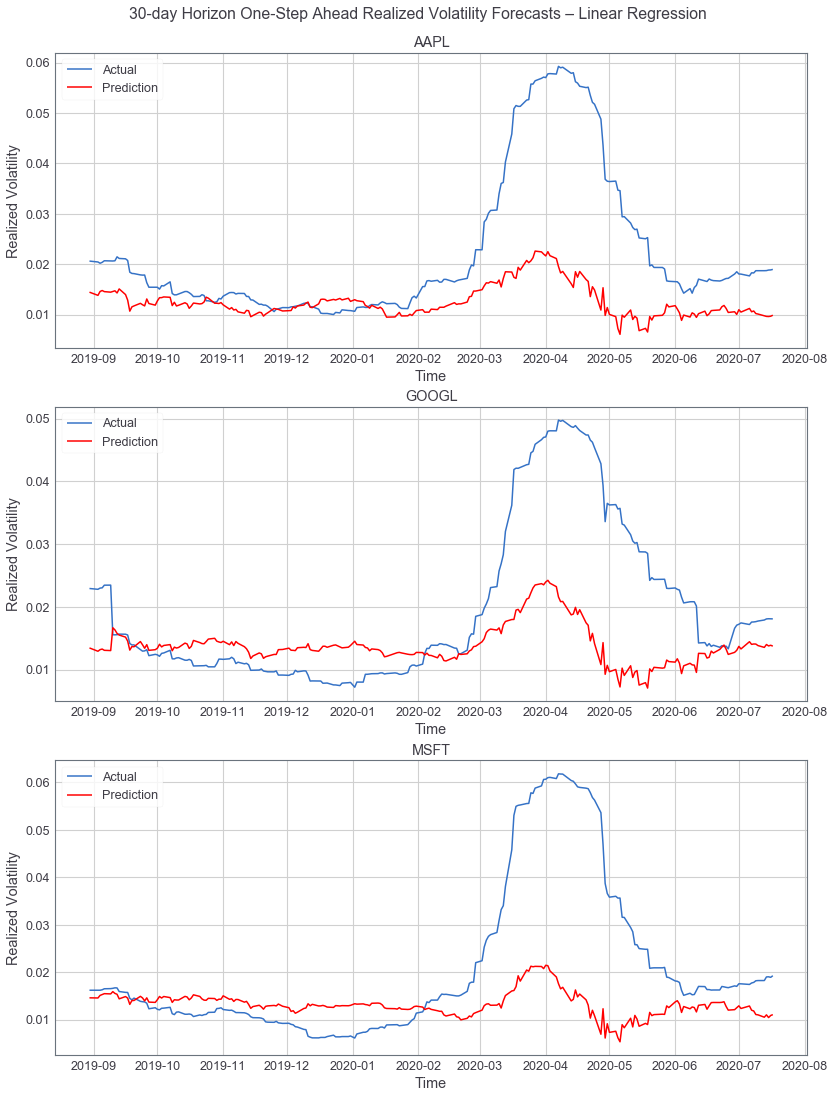

In [59]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

fig = plt.figure(figsize = (12,16))
fig.suptitle('30-day Horizon One-Step Ahead Realized Volatility Forecasts – Linear Regression')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.subplot(3, 1, 1)
plt.plot(y_temp_aapl, linewidth = 1.5)
plt.plot(y_pred_lr_aapl, linewidth = 1.5, color = 'red')
plt.title('AAPL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

plt.subplot(3, 1, 2)
plt.plot(y_temp_googl, linewidth = 1.5)
plt.plot(y_pred_lr_googl, linewidth = 1.5, color = 'red')
plt.title('GOOGL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

plt.subplot(3, 1, 3)
plt.plot(y_temp_msft, linewidth = 1.5)
plt.plot(y_pred_lr_msft, linewidth = 1.5, color = 'red')
plt.title('MSFT')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

In [60]:
from scipy.stats import pearsonr
corr_lr, _ = pearsonr(y_temp_aapl.values, y_pred_lr_aapl)
print("########################### AAPL ##########################")
print("Correlation: ",corr_lr)
print("R-Squared: ", corr_lr**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_aapl, y_pred_lr_aapl)))
print("MAPE: ", mean_absolute_error(y_temp_aapl, y_pred_lr_aapl))

print("########################### GOOGL ##########################")
corr_lr_googl, _ = pearsonr(y_temp_googl.values, y_pred_lr_googl)
print("Correlation: ",corr_lr_googl)
print("R-Squared: ", corr_lr_googl**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_googl, y_pred_lr_googl)))
print("MAPE: ", mean_absolute_error(y_temp_googl, y_pred_lr_googl))

print("########################### MSFT ##########################")
corr_lr_msft, _ = pearsonr(y_temp_msft.values, y_pred_lr_msft)
print("Correlation: ",corr_lr_msft)
print("R-Squared: ", corr_lr_msft**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_msft, y_pred_lr_msft)))
print("MAPE: ", mean_absolute_error(y_temp_msft, y_pred_lr_msft))

########################### AAPL ##########################
Correlation:  0.7345616243578947
R-Squared:  0.5395807799793089
RMSE:  0.015623389565539906
MAPE:  0.0101649132262856
########################### GOOGL ##########################
Correlation:  0.5210630078318292
R-Squared:  0.2715066581307529
RMSE:  0.012544381941742839
MAPE:  0.00849967659610497
########################### MSFT ##########################
Correlation:  0.3700953496612315
R-Squared:  0.1369705678408692
RMSE:  0.017331466158122796
MAPE:  0.010886540042586332


## SUPPORT VECTOR REGRESSION

In [61]:
from sklearn.svm import SVR
svr = SVR(C = 1000, epsilon = 0.0065, gamma = 0.02) 
svr.fit(x_train, y_train)

SVR(C=1000, epsilon=0.0065, gamma=0.02)

In [62]:
y_pred_svr = svr.predict(x_temp)
y_pred_svr_aapl = svr.predict(x_temp_aapl)
y_pred_svr_googl = svr.predict(x_temp_googl)
y_pred_svr_msft = svr.predict(x_temp_msft)

In [63]:
y_pred_svr_aapl = pd.Series(y_pred_svr_aapl.flatten())
y_pred_svr_googl = pd.Series(y_pred_svr_googl.flatten())
y_pred_svr_msft = pd.Series(y_pred_svr_msft.flatten())

y_pred_svr_aapl.index = y_temp_aapl.index
y_pred_svr_googl.index = y_temp_googl.index
y_pred_svr_msft.index = y_temp_msft.index

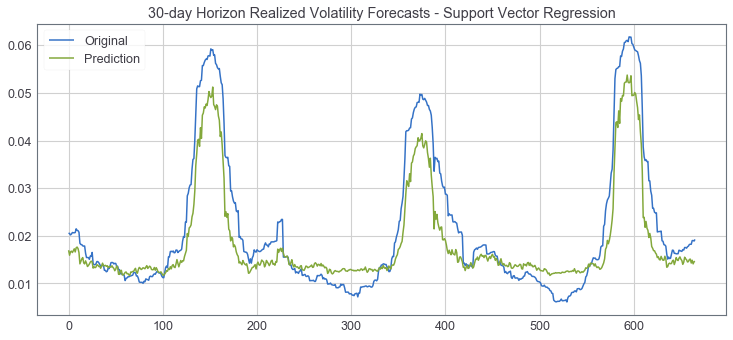

In [64]:
plt.figure(figsize=(11,5))
plt.plot(y_temp, linewidth = 1.5)
plt.plot(y_pred_svr, linewidth = 1.5)
plt.title('30-day Horizon Realized Volatility Forecasts - Support Vector Regression')
plt.legend(['Original', 'Prediction'], loc='upper left')

Text(0, 0.5, 'Realized Volatility')

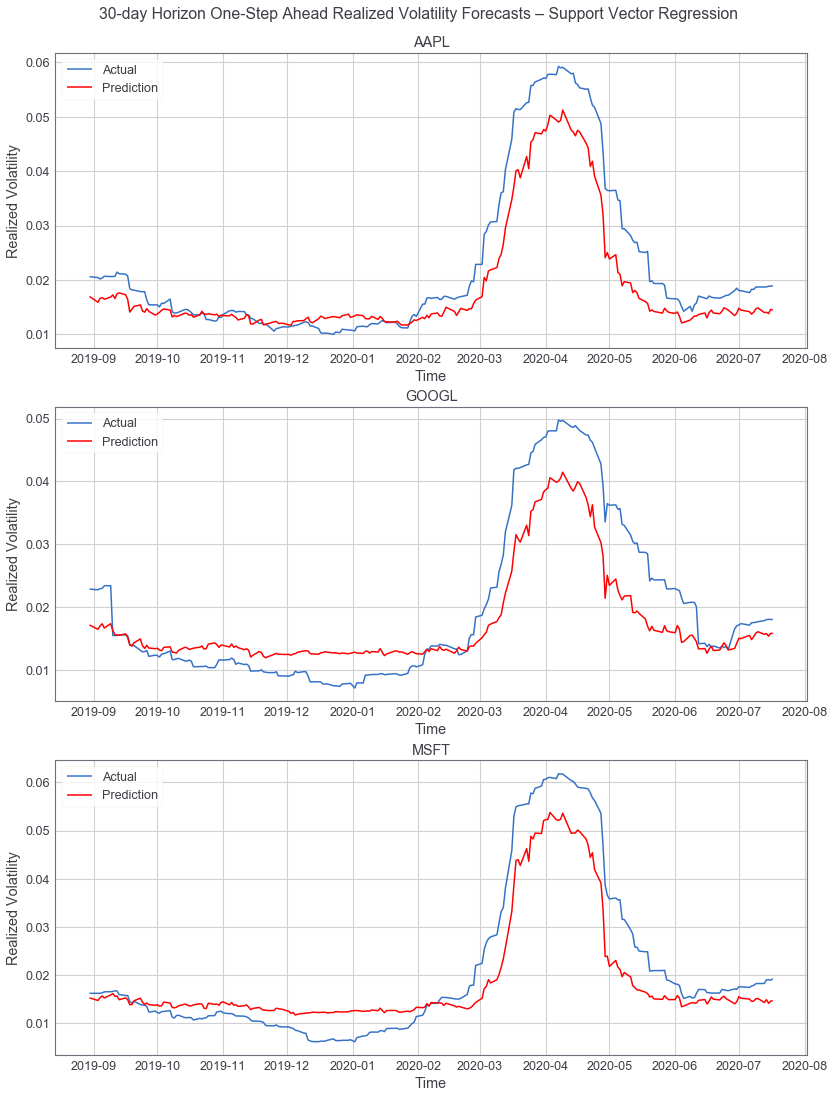

In [65]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

fig = plt.figure(figsize = (12,16))
fig.suptitle('30-day Horizon One-Step Ahead Realized Volatility Forecasts – Support Vector Regression')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.subplot(3, 1, 1)
plt.plot(y_temp_aapl, linewidth = 1.5)
plt.plot(y_pred_svr_aapl, linewidth = 1.5, color = 'red')
plt.title('AAPL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

plt.subplot(3, 1, 2)
plt.plot(y_temp_googl, linewidth = 1.5)
plt.plot(y_pred_svr_googl, linewidth = 1.5, color = 'red')
plt.title('GOOGL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

plt.subplot(3, 1, 3)
plt.plot(y_temp_msft, linewidth = 1.5)
plt.plot(y_pred_svr_msft, linewidth = 1.5, color = 'red')
plt.title('MSFT')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

In [66]:
corr_svr_aapl, _ = pearsonr(y_temp_aapl.values, y_pred_svr_aapl)
print("########################### AAPL ##########################")
print("Correlation FFN: ",corr_svr_aapl)
print("R-Squared FFN: ", corr_svr_aapl**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_aapl, y_pred_svr_aapl)))
print("MAPE: ", mean_absolute_error(y_temp_aapl, y_pred_svr_aapl))

print("########################### GOOGL ##########################")
corr_svr_googl, _ = pearsonr(y_temp_googl.values, y_pred_svr_googl)
print("Correlation FFN: ",corr_svr_googl)
print("R-Squared FFN: ", corr_svr_googl**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_googl, y_pred_svr_googl)))
print("MAPE: ", mean_absolute_error(y_temp_googl, y_pred_svr_googl))

print("########################### MSFT ##########################")
corr_svr_msft, _ = pearsonr(y_temp_msft.values, y_pred_svr_msft)
print("Correlation FFN: ",corr_svr_msft)
print("R-Squared FFN: ", corr_svr_msft**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_msft, y_pred_svr_msft)))
print("MAPE: ", mean_absolute_error(y_temp_msft, y_pred_svr_msft))

########################### AAPL ##########################
Correlation FFN:  0.9785531948060797
R-Squared FFN:  0.9575663550651854
RMSE:  0.005678388409880298
MAPE:  0.004211795916145003
########################### GOOGL ##########################
Correlation FFN:  0.956179861654371
R-Squared FFN:  0.914279927833372
RMSE:  0.005828484377603823
MAPE:  0.0045529282601223615
########################### MSFT ##########################
Correlation FFN:  0.9664508234234833
R-Squared FFN:  0.9340271940959289
RMSE:  0.006130465291774204
MAPE:  0.004789519996325456


## TENSORFLOW BASED FEED FORWARD NETWORK

In [67]:
n1 = 128
n2 = 64
n3 = 32
n = x_train.shape[1]

In [68]:
y_train = y_train.flatten()
y_train.shape

(2934,)

In [69]:
net = tf.InteractiveSession()
X = tf.placeholder(dtype=tf.float32, shape=[None, n])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Hidden weights
wh1 = tf.Variable(weight_initializer([n, n1]))
b1 = tf.Variable(bias_initializer([n1]))
wh2 = tf.Variable(weight_initializer([n1, n2]))
b2 = tf.Variable(bias_initializer([n2]))
wh3 = tf.Variable(weight_initializer([n2, n3]))
b3 = tf.Variable(bias_initializer([n3]))

# Output weights
W_out = tf.Variable(weight_initializer([n3, 1]))
bias_out = tf.Variable(bias_initializer([1]))

# Hidden layer
h1 = tf.nn.relu(tf.add(tf.matmul(X, wh1), b1))
drop_out = tf.nn.dropout(h1, 0.2)
h2 = tf.nn.relu(tf.add(tf.matmul(h1, wh2), b2))
#drop_out2 = tf.nn.dropout(h2, 0.3)
h3 = tf.nn.relu(tf.add(tf.matmul(h2, wh3), b3))

# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(h3, W_out), bias_out))

# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
opt = tf.train.AdamOptimizer(learning_rate = 0.01).minimize(mse)

# Init
net.run(tf.global_variables_initializer())

# Fit neural net
batch_size = 100
mse_train = []
mse_test = []

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [70]:
# Run
epochs = 64
for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    x_train_ffn = x_train[shuffle_indices]
    y_train_ffn = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train_ffn) // batch_size):
        start = i * batch_size
        batch_x = x_train_ffn[start:start + batch_size]
        batch_y = y_train_ffn[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})
        
     # Show progress
        if np.mod(i, 50) == 0:
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: x_train_ffn, Y: y_train_ffn}))
            mse_test.append(net.run(mse, feed_dict={X: x_temp, Y: y_temp}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
            # Prediction
            pred = net.run(out, feed_dict={X: x_temp})

MSE Train:  0.01962004
MSE Test:  0.020104771
MSE Train:  4.7379952e-05
MSE Test:  0.00028205756
MSE Train:  1.7677265e-05
MSE Test:  0.00015768298
MSE Train:  1.3901501e-05
MSE Test:  0.00011670972
MSE Train:  1.0720046e-05
MSE Test:  8.628666e-05
MSE Train:  7.4814902e-06
MSE Test:  4.933506e-05
MSE Train:  5.368009e-06
MSE Test:  3.298989e-05
MSE Train:  4.5876063e-06
MSE Test:  2.6833437e-05
MSE Train:  3.8270837e-06
MSE Test:  2.1627884e-05
MSE Train:  3.7046002e-06
MSE Test:  1.3014654e-05
MSE Train:  2.8473248e-06
MSE Test:  1.42518975e-05
MSE Train:  2.561181e-06
MSE Test:  1.1929178e-05
MSE Train:  2.4971225e-06
MSE Test:  1.1130631e-05
MSE Train:  2.2430759e-06
MSE Test:  9.824623e-06
MSE Train:  2.3675432e-06
MSE Test:  1.019387e-05
MSE Train:  1.94981e-06
MSE Test:  8.579751e-06
MSE Train:  3.05658e-06
MSE Test:  8.428383e-06
MSE Train:  2.235092e-06
MSE Test:  8.7993385e-06
MSE Train:  1.6949762e-06
MSE Test:  8.6964255e-06
MSE Train:  1.5639727e-06
MSE Test:  8.190499e-06

In [71]:
pred = net.run(out, feed_dict={X: x_temp})
pred_aapl = net.run(out, feed_dict={X: x_temp_aapl})
pred_googl = net.run(out, feed_dict={X: x_temp_googl})
pred_msft = net.run(out, feed_dict={X: x_temp_msft})

pred = pred.flatten()
pred_aapl = pred_aapl.flatten()
pred_googl = pred_googl.flatten()
pred_msft = pred_msft.flatten()

In [72]:
pred_aapl = pd.Series(pred_aapl)
pred_googl = pd.Series(pred_googl)
pred_msft = pd.Series(pred_msft)

pred_aapl.index = y_temp_aapl.index
pred_googl.index = y_temp_googl.index
pred_msft.index = y_temp_msft.index

Text(0, 0.5, 'Returns')

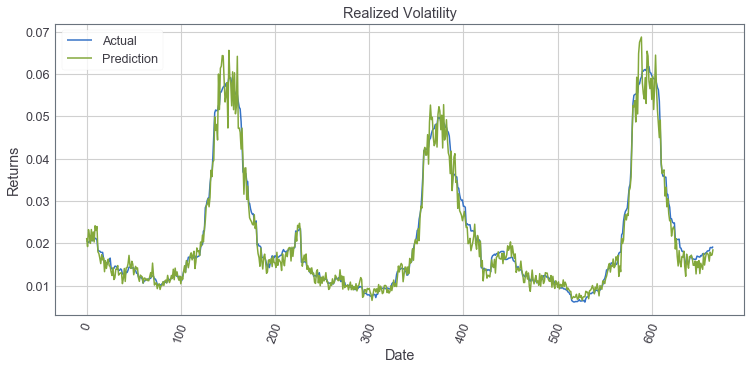

In [73]:
from jupyterthemes import jtplot
jtplot.style(theme = 'grade3')

plt.figure(figsize=(11,5))
plt.plot(y_temp, linewidth = 1.5)
plt.plot(pred, linewidth = 1.5)

plt.xticks(rotation=70)
plt.title('Realized Volatility')
plt.legend(['Actual', 'Prediction', ], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Returns")

Text(0, 0.5, 'Realized Volatility')

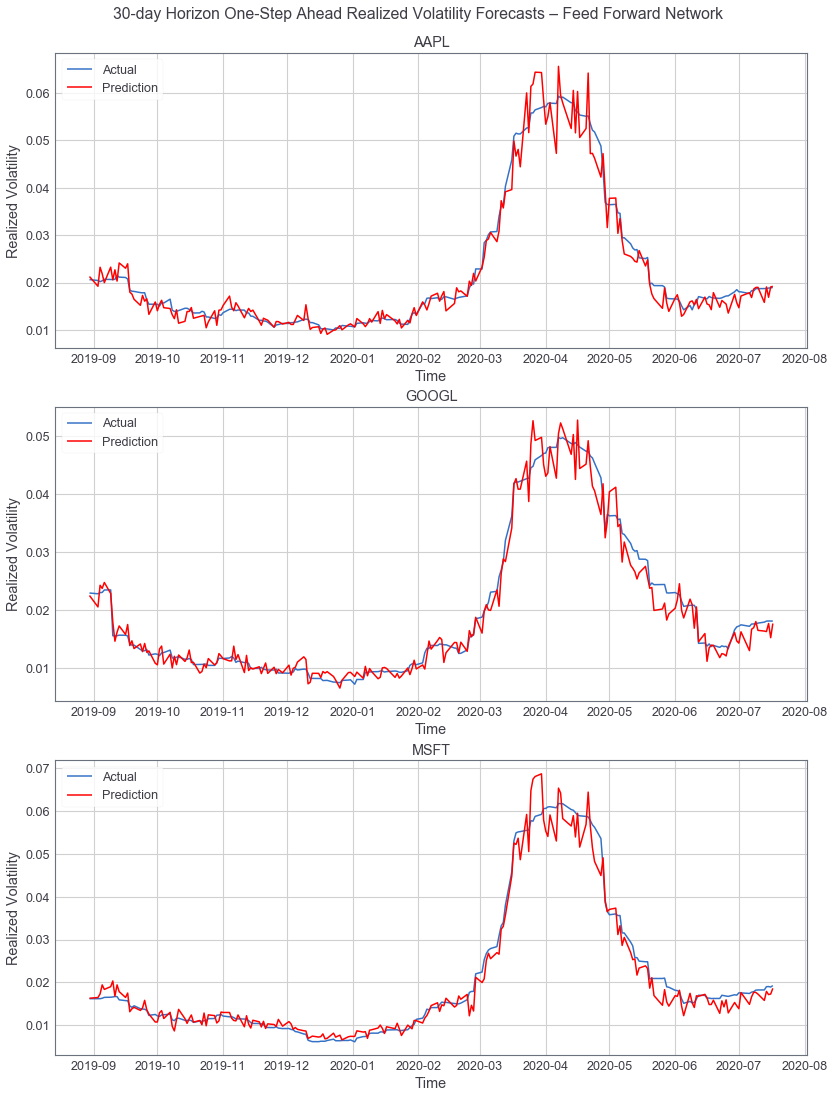

In [74]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

fig = plt.figure(figsize = (12,16))
fig.suptitle('30-day Horizon One-Step Ahead Realized Volatility Forecasts – Feed Forward Network')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.subplot(3, 1, 1)
plt.plot(y_temp_aapl, linewidth = 1.5)
plt.plot(pred_aapl, linewidth = 1.5, color = 'red')
plt.title('AAPL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

plt.subplot(3, 1, 2)
plt.plot(y_temp_googl, linewidth = 1.5)
plt.plot(pred_googl, linewidth = 1.5, color = 'red')
plt.title('GOOGL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

plt.subplot(3, 1, 3)
plt.plot(y_temp_msft, linewidth = 1.5)
plt.plot(pred_msft, linewidth = 1.5, color = 'red')
plt.title('MSFT')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

In [75]:
corr_ffn_aapl, _ = pearsonr(y_temp_aapl.values, pred_aapl)
print("########################### AAPL ##########################")
print("Correlation FFN: ",corr_ffn_aapl)
print("R-Squared FFN: ", corr_ffn_aapl**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_aapl, pred_aapl)))
print("MAPE: ", mean_absolute_error(y_temp_aapl, pred_aapl))

print("########################### GOOGL ##########################")
corr_ffn_googl, _ = pearsonr(y_temp_googl.values, pred_googl)
print("Correlation FFN: ",corr_ffn_googl)
print("R-Squared FFN: ", corr_ffn_googl**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_googl, pred_googl)))
print("MAPE: ", mean_absolute_error(y_temp_googl, pred_googl))

print("########################### MSFT ##########################")
corr_ffn_msft, _ = pearsonr(y_temp_msft.values, pred_msft)
print("Correlation FFN: ",corr_ffn_msft)
print("R-Squared FFN: ", corr_ffn_msft**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_msft, pred_msft)))
print("MAPE: ", mean_absolute_error(y_temp_msft, pred_msft))

########################### AAPL ##########################
Correlation FFN:  0.9855849861997963
R-Squared FFN:  0.9713777650224527
RMSE:  0.002455275169475865
MAPE:  0.0016803579256587208
########################### GOOGL ##########################
Correlation FFN:  0.9868754908254708
R-Squared FFN:  0.9739232343920139
RMSE:  0.002057879050317895
MAPE:  0.0015119044653628115
########################### MSFT ##########################
Correlation FFN:  0.9877090911699946
R-Squared FFN:  0.9755692487798567
RMSE:  0.0025812048391556
MAPE:  0.0017810976147256984


## LSTM NEURAL NETWORK

In [301]:
from keras.layers import InputLayer, Dense, Dropout, LSTM, GRU
from keras.models import Sequential
from keras import optimizers

lstm_model = Sequential()
(LSTM(32, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_train_lstm.shape[2]),
                    dropout=0.0, recurrent_dropout=0.4, stateful=True, return_sequences=True,
                    kernel_initializer='random_uniform'))
#lstm_model.add(Dense(32, activation = 'relu'))
#lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(128, activation = 'relu'))
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(1))
optimizer = optimizers.Adam(learning_rate = 0.0014)
lstm_model.compile(optimizer= optimizer ,loss='mean_squared_error')
history = lstm_model.fit(x_train_lstm, y_train_lstm, epochs=20, batch_size=BATCH_SIZE, validation_data=(trim_dataset(x_val_lstm, BATCH_SIZE),
                        trim_dataset(y_val_lstm, BATCH_SIZE)))

Train on 2880 samples, validate on 320 samples
Epoch 1/20
2880/2880 [==============================] - 12s 4ms/step - loss: 2.8459e-05 - val_loss: 1.5104e-05
Epoch 2/20
2880/2880 [==============================] - 9s 3ms/step - loss: 8.4400e-06 - val_loss: 1.2881e-05
Epoch 3/20
2880/2880 [==============================] - 8s 3ms/step - loss: 5.1123e-06 - val_loss: 2.2562e-05
Epoch 4/20
2880/2880 [==============================] - 9s 3ms/step - loss: 4.5018e-06 - val_loss: 3.3573e-05
Epoch 5/20
2880/2880 [==============================] - 9s 3ms/step - loss: 2.5847e-06 - val_loss: 2.4458e-05
Epoch 6/20
2880/2880 [==============================] - 9s 3ms/step - loss: 2.7328e-06 - val_loss: 3.1744e-05
Epoch 7/20
2880/2880 [==============================] - 10s 3ms/step - loss: 2.5502e-06 - val_loss: 3.5679e-05
Epoch 8/20
2880/2880 [==============================] - 9s 3ms/step - loss: 1.8906e-06 - val_loss: 1.5930e-05
Epoch 9/20
2880/2880 [==============================] - 10s 3ms/step - 

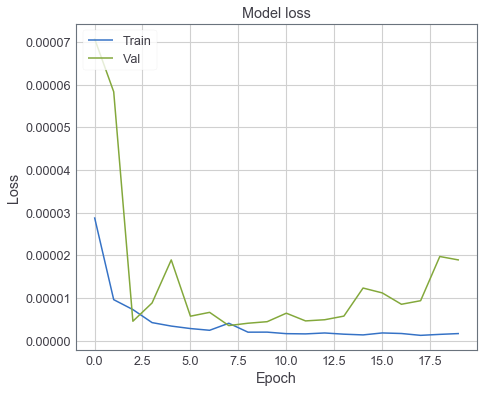

In [297]:
# Plot learning curve
plt.figure()
plt.plot(history.history['loss'], linewidth = 1.5)
plt.plot(history.history['val_loss'], linewidth = 1.5)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

In [298]:
#print(pred_lstm.shape, pred_lstm_aapl.shape)
pred_lstm = lstm_model.predict(x_temp_lstm, batch_size = BATCH_SIZE)
pred_lstm_aapl = lstm_model.predict(x_temp_aapl_lstm, batch_size = BATCH_SIZE)
pred_lstm_googl = lstm_model.predict(x_temp_googl_lstm, batch_size = BATCH_SIZE)
pred_lstm_msft = lstm_model.predict(x_temp_msft_lstm, batch_size = BATCH_SIZE)

In [299]:
pred_lstm_aapl = pd.Series(pred_lstm_aapl.flatten())
pred_lstm_googl = pd.Series(pred_lstm_googl.flatten())
pred_lstm_msft = pd.Series(pred_lstm_msft.flatten())

pred_lstm_aapl.index = y_temp_aapl.index[: -2]
pred_lstm_googl.index = y_temp_googl.index[: -2]
pred_lstm_msft.index = y_temp_msft.index[: -2]

Text(0, 0.5, 'Returns')

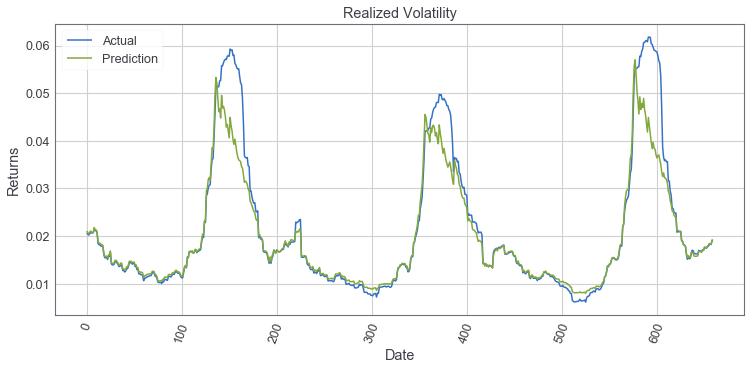

In [300]:
from jupyterthemes import jtplot
jtplot.style(theme = 'grade3')

plt.figure(figsize=(11,5))
plt.plot(y_temp_lstm, linewidth = 1.5)
plt.plot(pred_lstm, linewidth = 1.5)

plt.xticks(rotation=70)
plt.title('Realized Volatility')
plt.legend(['Actual', 'Prediction', ], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Returns")

Text(0, 0.5, 'Realized Volatility')

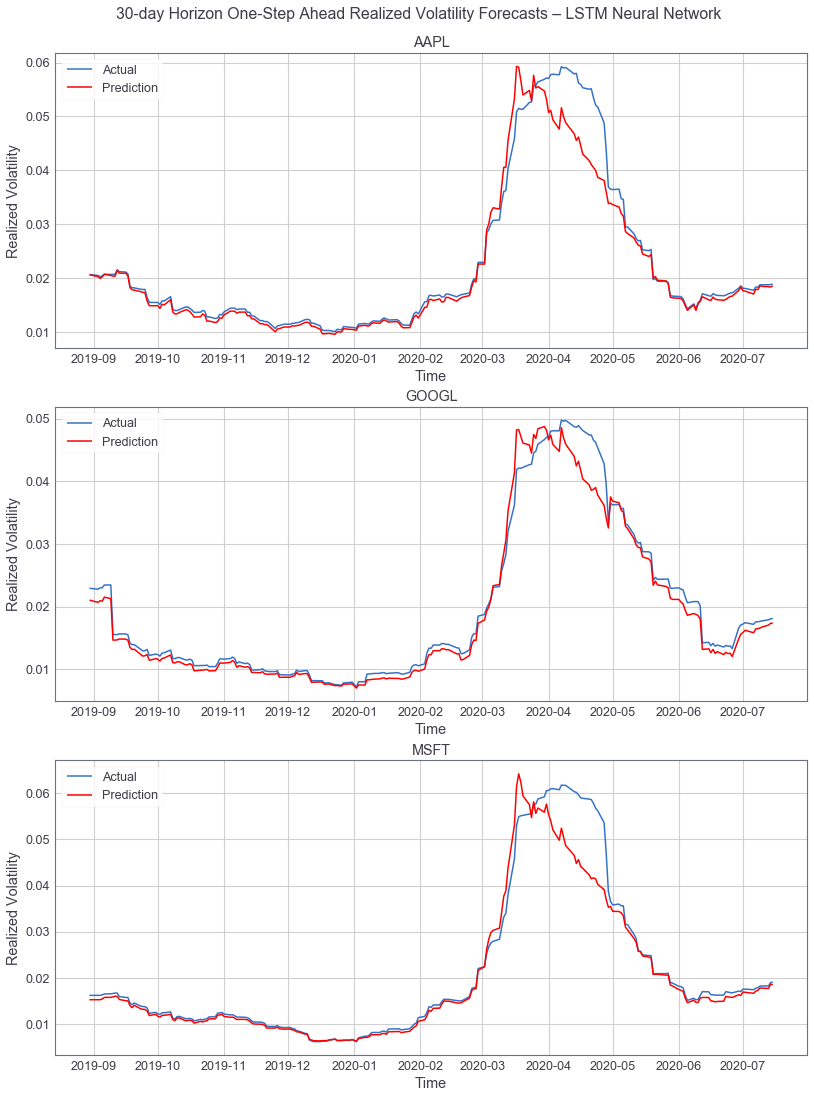

In [290]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

fig = plt.figure(figsize = (12,16))
fig.suptitle('30-day Horizon One-Step Ahead Realized Volatility Forecasts – LSTM Neural Network')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.subplot(3, 1, 1)
plt.plot(y_temp_aapl_lstm, linewidth = 1.5)
plt.plot(pred_lstm_aapl, linewidth = 1.5, color = 'red')
plt.title('AAPL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

plt.subplot(3, 1, 2)
plt.plot(y_temp_googl_lstm, linewidth = 1.5)
plt.plot(pred_lstm_googl, linewidth = 1.5, color = 'red')
plt.title('GOOGL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

plt.subplot(3, 1, 3)
plt.plot(y_temp_msft_lstm, linewidth = 1.5)
plt.plot(pred_lstm_msft, linewidth = 1.5, color = 'red')
plt.title('MSFT')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Time")
plt.ylabel("Realized Volatility")

In [94]:
corr_lstm_aapl, _ = pearsonr(y_temp_aapl_lstm.values, pred_lstm_aapl)
print("########################### AAPL ##########################")
print("Correlation FFN: ",corr_lstm_aapl)
print("R-Squared FFN: ", corr_lstm_aapl**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_aapl_lstm, pred_lstm_aapl)))
print("MAPE: ", mean_absolute_error(y_temp_aapl_lstm, pred_lstm_aapl))

print("########################### GOOGL ##########################")
corr_lstm_googl, _ = pearsonr(y_temp_googl_lstm.values, pred_lstm_googl)
print("Correlation FFN: ",corr_lstm_googl)
print("R-Squared FFN: ", corr_lstm_googl**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_googl_lstm, pred_lstm_googl)))
print("MAPE: ", mean_absolute_error(y_temp_googl_lstm, pred_lstm_googl))

print("########################### MSFT ##########################")
corr_lstm_msft, _ = pearsonr(y_temp_msft_lstm.values, pred_lstm_msft)
print("Correlation FFN: ",corr_lstm_msft)
print("R-Squared FFN: ", corr_lstm_msft**2)
print("RMSE: ", np.sqrt(mean_squared_error(y_temp_msft_lstm, pred_lstm_msft)))
print("MAPE: ", mean_absolute_error(y_temp_msft_lstm, pred_lstm_msft))

########################### AAPL ##########################
Correlation FFN:  0.9722771600490215
R-Squared FFN:  0.9453228759529907
RMSE:  0.003497886187321637
MAPE:  0.0016414052667587515
########################### GOOGL ##########################
Correlation FFN:  0.9856389963665644
R-Squared FFN:  0.9714842311584884
RMSE:  0.0021115812968703295
MAPE:  0.0010453514409412715
########################### MSFT ##########################
Correlation FFN:  0.9701997708924668
R-Squared FFN:  0.941287595439795
RMSE:  0.004205105165447915
MAPE:  0.00197829525687756


## MULTI STEP MODEL

In [124]:
from keras.layers import InputLayer, Dense, Dropout, LSTM, GRU
from keras.models import Sequential
from keras import optimizers

lstm_model_multi = Sequential()
lstm_model_multi.add(Dense(32, activation = 'relu'))
lstm_model_multi.add(LSTM(16))
lstm_model_multi.add(Dropout(0.2))
lstm_model_multi.add(Dense(30))
optimizer = optimizers.Adam(learning_rate = 0.0025)
lstm_model_multi.compile(optimizer= optimizer ,loss='mean_squared_error')
#lstm_model_multi.fit(x_train_multi, y_train_multi, epochs=32, batch_size=BATCH_SIZE)
history_multi = lstm_model_multi.fit(x_train_multi, y_train_multi, epochs=32, batch_size=BATCH_SIZE, validation_data=(trim_dataset(x_val_multi, BATCH_SIZE),
                        trim_dataset(y_val_multi, BATCH_SIZE)))

Train on 2840 samples, validate on 280 samples
Epoch 1/32
2840/2840 [==============================] - 4s 1ms/step - loss: 2.9158e-05 - val_loss: 1.3891e-04
Epoch 2/32
2840/2840 [==============================] - 3s 1ms/step - loss: 1.3228e-05 - val_loss: 6.9231e-05
Epoch 3/32
2840/2840 [==============================] - 3s 1ms/step - loss: 1.3593e-05 - val_loss: 6.1970e-05
Epoch 4/32
2840/2840 [==============================] - 3s 1ms/step - loss: 1.1979e-05 - val_loss: 5.9801e-05
Epoch 5/32
2840/2840 [==============================] - 3s 1ms/step - loss: 1.1885e-05 - val_loss: 5.9402e-05
Epoch 6/32
2840/2840 [==============================] - 3s 1ms/step - loss: 1.1086e-05 - val_loss: 5.8361e-05
Epoch 7/32
2840/2840 [==============================] - 3s 1ms/step - loss: 1.0694e-05 - val_loss: 5.5591e-05
Epoch 8/32
2840/2840 [==============================] - 3s 1ms/step - loss: 1.0289e-05 - val_loss: 5.6664e-05
Epoch 9/32
2840/2840 [==============================] - 3s 1ms/step - los

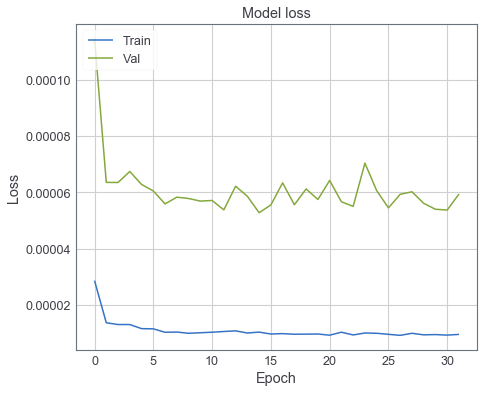

In [120]:
# Plot learning curve
plt.figure()
plt.plot(history_multi.history['loss'], linewidth = 1.5)
plt.plot(history_multi.history['val_loss'], linewidth = 1.5)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

In [121]:
pred_multi = lstm_model_multi.predict(x_temp_multi, batch_size = BATCH_SIZE)
pred_multi_aapl = lstm_model_multi.predict(x_temp_aapl_multi, batch_size = BATCH_SIZE)
pred_multi_googl = lstm_model_multi.predict(x_temp_googl_multi, batch_size = BATCH_SIZE)
pred_multi_msft = lstm_model_multi.predict(x_temp_msft_multi, batch_size = BATCH_SIZE)

Text(0, 0.5, 'Realised Volatility')

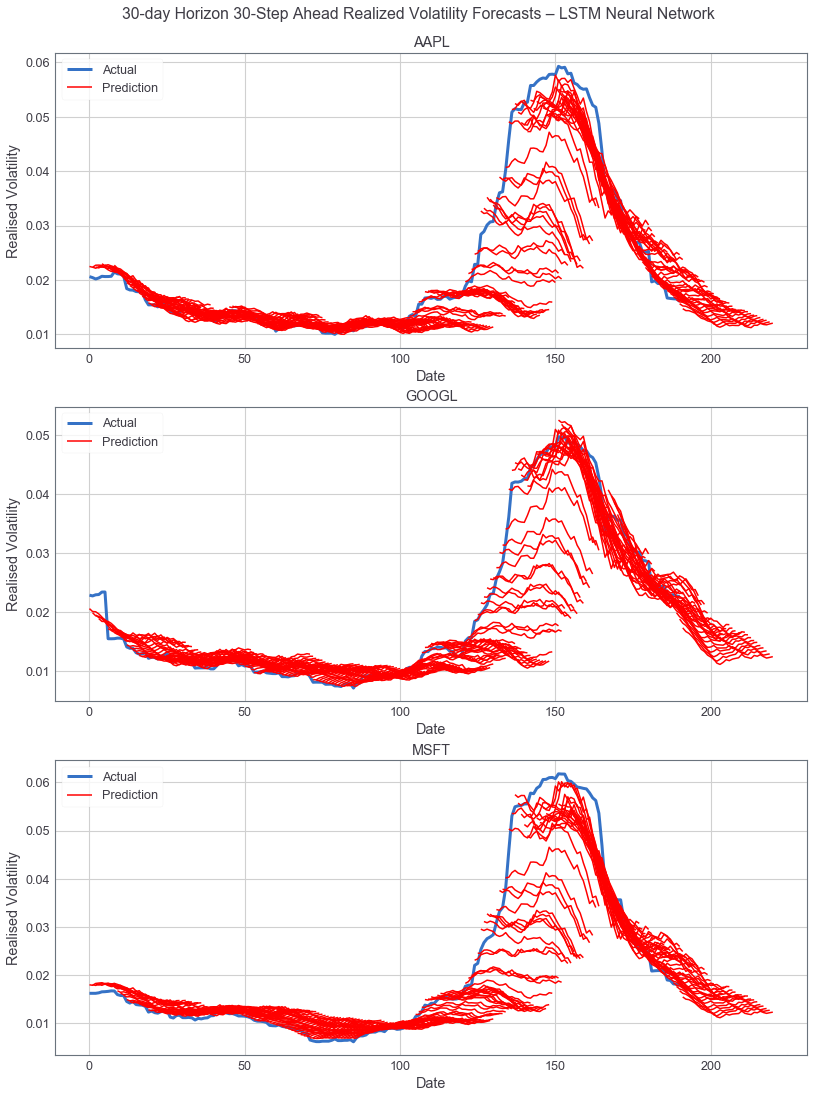

In [122]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

fig = plt.figure(figsize = (12,16))
fig.suptitle('30-day Horizon 30-Step Ahead Realized Volatility Forecasts – LSTM Neural Network')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.subplot(3, 1, 1)
plt.plot(aapl['Rel_vol'][TIME_STEPS + len(df_train_aapl) : TIME_STEPS + len(df_train_aapl) + len(y_temp_aapl_multi) - 1].values, linewidth = 3.0)
count = 0
for i in range(len(pred_multi_aapl)):
    xaxis = np.arange(count, count + 30)
    count = count + 1
    plt.plot(xaxis, pred_multi_aapl[i], linewidth = 1.5, color = 'red')
plt.title('AAPL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Realised Volatility")

plt.subplot(3, 1, 2)
plt.plot(googl['Rel_vol'][TIME_STEPS + len(df_train_googl) : TIME_STEPS + len(df_train_googl) + len(y_temp_googl_multi) - 1].values, linewidth = 3.0)
count = 0
for i in range(len(pred_multi_googl)):
    xaxis = np.arange(count, count + 30)
    count = count + 1
    plt.plot(xaxis, pred_multi_googl[i], linewidth = 1.5, color = 'red')
plt.title('GOOGL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Realised Volatility")

plt.subplot(3, 1, 3)
plt.plot(msft['Rel_vol'][TIME_STEPS + len(df_train_msft) : TIME_STEPS + len(df_train_msft) + len(y_temp_msft_multi) - 1].values, linewidth = 3.0)
count = 0
for i in range(len(pred_multi_msft)):
    xaxis = np.arange(count, count + 30)
    count = count + 1
    plt.plot(xaxis, pred_multi_msft[i], linewidth = 1.5, color = 'red')
plt.title('MSFT')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Realised Volatility")


Text(0, 0.5, 'Realised Volatility')

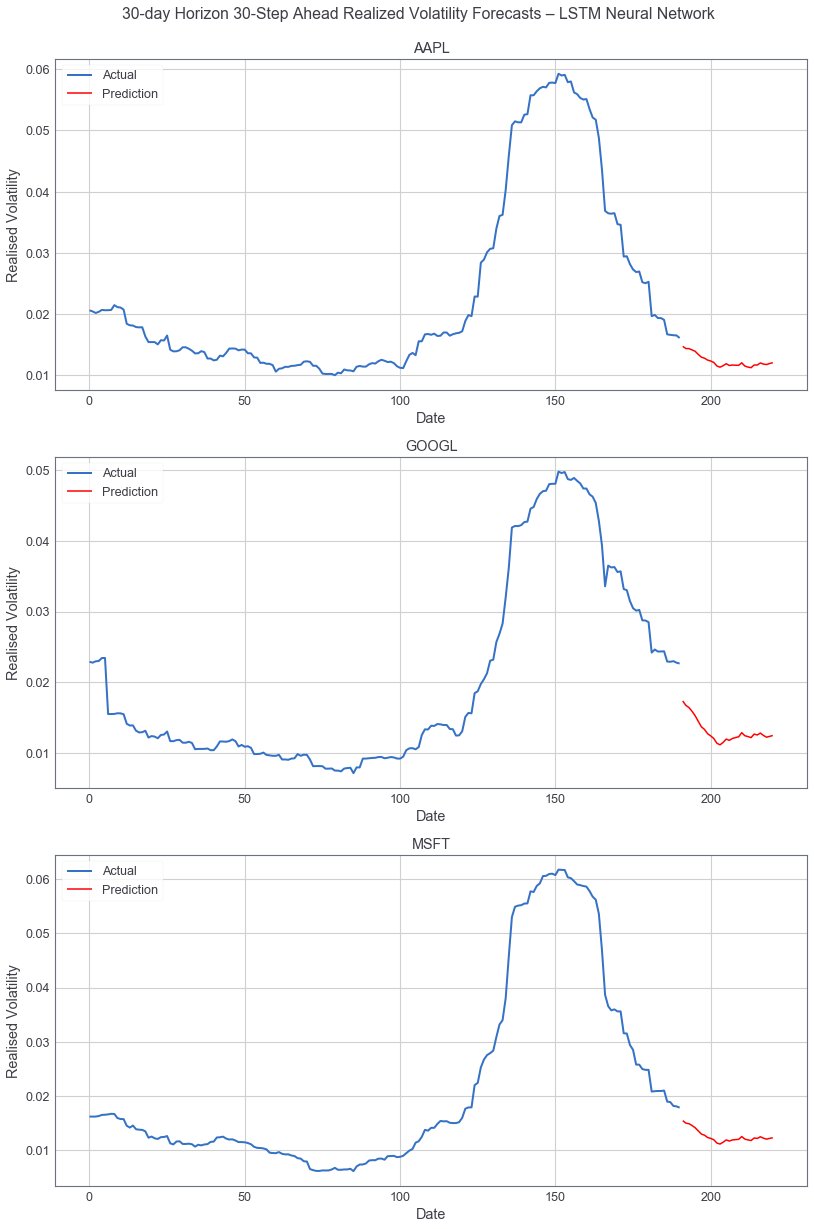

In [123]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

plotSeries_aapl = aapl['Rel_vol'][TIME_STEPS + len(df_train_aapl) : TIME_STEPS + len(df_train_aapl) + len(y_temp_aapl_multi) - 1]
actualSeries_aapl = aapl['Rel_vol'][TIME_STEPS + len(df_train_aapl) : ]

plotSeries_googl = googl['Rel_vol'][TIME_STEPS + len(df_train_googl) : TIME_STEPS + len(df_train_googl) + len(y_temp_googl_multi) - 1]
actualSeries_googl = googl['Rel_vol'][TIME_STEPS + len(df_train_googl) : ]

plotSeries_msft = msft['Rel_vol'][TIME_STEPS + len(df_train_msft) : TIME_STEPS + len(df_train_msft) + len(y_temp_msft_multi) - 1]
actualSeries_msft = msft['Rel_vol'][TIME_STEPS + len(df_train_msft) : ]


fig = plt.figure(figsize = (12,18))
fig.suptitle('30-day Horizon 30-Step Ahead Realized Volatility Forecasts – LSTM Neural Network')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.subplot(3, 1, 1)
plt.plot(plotSeries_aapl.values, linewidth = 2.0)
xaxis_aapl = np.arange(len(plotSeries_aapl - 1), len(plotSeries_aapl - 1) + 30)
plt.plot(xaxis_aapl, pred_multi_aapl[len(pred_multi_aapl) - 1], linewidth = 1.5, color = 'red')
plt.title('AAPL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Realised Volatility")

plt.subplot(3, 1, 2)
plt.plot(plotSeries_googl.values, linewidth = 2.0)
xaxis_googl = np.arange(len(plotSeries_googl - 1), len(plotSeries_googl - 1) + 30)
plt.plot(xaxis_googl, pred_multi_googl[len(pred_multi_googl) - 1], linewidth = 1.5, color = 'red')
plt.title('GOOGL')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Realised Volatility")

plt.subplot(3, 1, 3)
plt.plot(plotSeries_msft.values, linewidth = 2.0)
xaxis_msft = np.arange(len(plotSeries_msft - 1), len(plotSeries_msft - 1) + 30)
plt.plot(xaxis_msft, pred_multi_msft[len(pred_multi_msft) - 1], linewidth = 1.5, color = 'red')
plt.title('MSFT')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Realised Volatility")

In [104]:
actualSeries_aapl[-30:]

Date
2020-06-05    0.014264
2020-06-08    0.015166
2020-06-09    0.014261
2020-06-10    0.015382
2020-06-11    0.015809
2020-06-12    0.017052
2020-06-15    0.016686
2020-06-16    0.016580
2020-06-17    0.017077
2020-06-18    0.016858
2020-06-19    0.016752
2020-06-22    0.016678
2020-06-23    0.016796
2020-06-24    0.017001
2020-06-25    0.017177
2020-06-26    0.017207
2020-06-29    0.018064
2020-06-30    0.018516
2020-07-01    0.018073
2020-07-02    0.018046
2020-07-06    0.017693
2020-07-07    0.018304
2020-07-08    0.018275
2020-07-09    0.018723
2020-07-10    0.018722
2020-07-13    0.018725
2020-07-14    0.018743
2020-07-15    0.018852
2020-07-16    0.018874
2020-07-17    0.018981
Name: Rel_vol, dtype: float64

Text(0, 0.5, 'Realised Volatility')

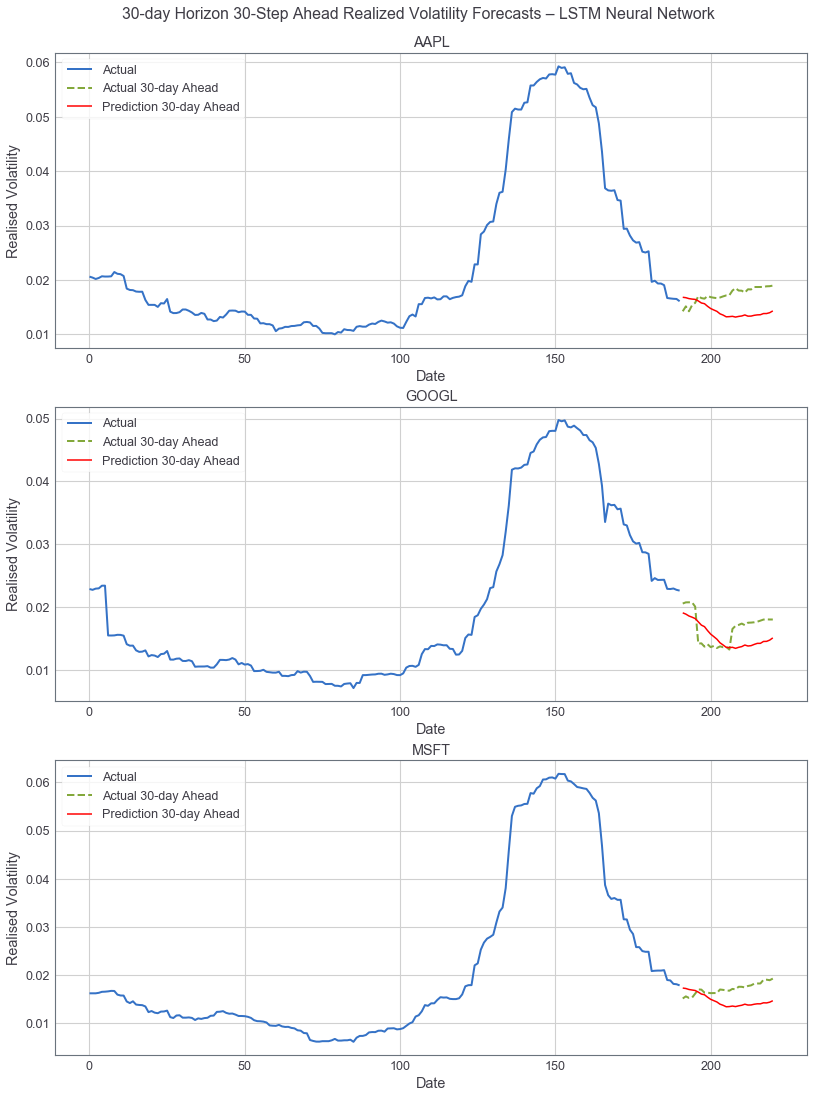

In [105]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

plotSeries_aapl = aapl['Rel_vol'][TIME_STEPS + len(df_train_aapl) : TIME_STEPS + len(df_train_aapl) + len(y_temp_aapl_multi) - 1]
actualSeries_aapl = aapl['Rel_vol'][TIME_STEPS + len(df_train_aapl) : ]

plotSeries_googl = googl['Rel_vol'][TIME_STEPS + len(df_train_googl) : TIME_STEPS + len(df_train_googl) + len(y_temp_googl_multi) - 1]
actualSeries_googl = googl['Rel_vol'][TIME_STEPS + len(df_train_googl) : ]

plotSeries_msft = msft['Rel_vol'][TIME_STEPS + len(df_train_msft) : TIME_STEPS + len(df_train_msft) + len(y_temp_msft_multi) - 1]
actualSeries_msft = msft['Rel_vol'][TIME_STEPS + len(df_train_msft) : ]


fig = plt.figure(figsize = (12,16))
fig.suptitle('30-day Horizon 30-Step Ahead Realized Volatility Forecasts – LSTM Neural Network')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.subplot(3, 1, 1)
plt.plot(plotSeries_aapl.values, linewidth = 2.0)
xaxis_aapl = np.arange(len(plotSeries_aapl - 1), len(plotSeries_aapl - 1) + 30)
plt.plot(xaxis_aapl, actualSeries_aapl[-30:], linewidth = 2.0, linestyle = '--')
plt.plot(xaxis_aapl, pred_multi_aapl[len(pred_multi_aapl) - 1], linewidth = 1.5, color = 'red')
plt.title('AAPL')
plt.legend(['Actual', 'Actual 30-day Ahead', 'Prediction 30-day Ahead'], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Realised Volatility")

plt.subplot(3, 1, 2)
plt.plot(plotSeries_googl.values, linewidth = 2.0)
xaxis_googl = np.arange(len(plotSeries_googl - 1), len(plotSeries_googl - 1) + 30)
plt.plot(xaxis_googl, actualSeries_googl[-30:], linewidth = 2.0, linestyle = '--')
plt.plot(xaxis_googl, pred_multi_googl[len(pred_multi_googl) - 1], linewidth = 1.5, color = 'red')
plt.title('GOOGL')
plt.legend(['Actual', 'Actual 30-day Ahead', 'Prediction 30-day Ahead'], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Realised Volatility")

plt.subplot(3, 1, 3)
plt.plot(plotSeries_msft.values, linewidth = 2.0)
xaxis_msft = np.arange(len(plotSeries_msft - 1), len(plotSeries_msft - 1) + 30)
plt.plot(xaxis_msft, actualSeries_msft[-30:], linewidth = 2.0, linestyle = '--')
plt.plot(xaxis_msft, pred_multi_msft[len(pred_multi_msft) - 1], linewidth = 1.5, color = 'red')
plt.title('MSFT')
plt.legend(['Actual', 'Actual 30-day Ahead', 'Prediction 30-day Ahead'], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Realised Volatility")


In [106]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, eval_list):
    for i in range(TIME_STEPS):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        eval_list[i] = rmse
        #print('t + %d RMSE: %f' % ((i+1), rmse))
    return eval_list

# evaluate the RMSE for each forecast time step
def evaluate_forecasts_mape(test, forecasts, eval_list):
    for i in range(TIME_STEPS):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        mape = mean_absolute_error(actual, predicted)
        eval_list[i] = mape
        #print('t + %d RMSE: %f' % ((i+1), rmse))
    return eval_list

In [107]:
aapl_eval = [np.nan] * TIME_STEPS
googl_eval = [np.nan] * TIME_STEPS
msft_eval = [np.nan] * TIME_STEPS
aapl_eval_mape = [np.nan] * TIME_STEPS
googl_eval_mape = [np.nan] * TIME_STEPS
msft_eval_mape = [np.nan] * TIME_STEPS

aapl_eval = evaluate_forecasts(y_temp_aapl_multi, pred_multi_aapl, aapl_eval)
googl_eval = evaluate_forecasts(y_temp_googl_multi, pred_multi_googl, googl_eval)
msft_eval = evaluate_forecasts(y_temp_msft_multi, pred_multi_msft, msft_eval)
aapl_eval_mape = evaluate_forecasts_mape(y_temp_aapl_multi, pred_multi_aapl, aapl_eval_mape)
googl_eval_mape = evaluate_forecasts_mape(y_temp_googl_multi, pred_multi_googl, googl_eval_mape)
msft_eval_mape = evaluate_forecasts_mape(y_temp_msft_multi, pred_multi_msft, msft_eval_mape)

In [108]:
t_days = [np.nan] * TIME_STEPS
for i in range(TIME_STEPS):
    t_days[i] = "t + " + str(i+1)

In [109]:
rmse_df = pd.DataFrame(list(zip(t_days, aapl_eval, googl_eval, msft_eval, aapl_eval_mape, googl_eval_mape, msft_eval_mape)), columns = ['Day', 'AAPL', 'GOOGL', 'MSFT', 'AAPL_MAPE', 'GOOGL_MAPE', 'MSFT_MAPE'])
rmse_df.index.name = None
rmse_df.head()

,Day,AAPL,GOOGL,MSFT,AAPL_MAPE,GOOGL_MAPE,MSFT_MAPE
0,t + 1,0.002301,0.002449,0.003010,0.002055,0.002279,0.002677
1,t + 2,0.002303,0.002464,0.002993,0.002080,0.002265,0.002672
2,t + 3,0.002365,0.002580,0.003078,0.002097,0.002310,0.002718
3,t + 4,0.002644,0.002863,0.003390,0.002330,0.002523,0.002959
4,t + 5,0.002988,0.003177,0.003780,0.002592,0.002775,0.003234


In [110]:
rmse_df.to_excel("rmse_df.xlsx") 

In [111]:
print(min(aapl_eval))
print(min(googl_eval))
print(min(msft_eval))
print(min(aapl_eval_mape))
print(min(googl_eval_mape))
print(min(msft_eval_mape))

0.0023006724412239186
0.002448611207391195
0.0029929499255611563
0.0020550745128949215
0.0022650562146997646
0.002672172833027221


In [112]:
print(max(aapl_eval))
print(max(googl_eval))
print(max(msft_eval))
print(max(aapl_eval_mape))
print(max(googl_eval_mape))
print(max(msft_eval_mape))

0.014642154203237603
0.011624634576831952
0.016184909668906525
0.00943961291324065
0.0077438166310636325
0.010775775196123875


In [113]:
test_direction = [np.nan] * len(y_temp_aapl_multi)

for i in range(len(y_temp_aapl_multi)):
    if y_temp_aapl_multi[i][29] > y_temp_aapl_multi[i][0]:
        test_direction[i] = 1
    else:
        test_direction[i] = 0
        
test_direction_googl = [np.nan] * len(y_temp_googl_multi)
for i in range(len(y_temp_googl_multi)):
    if y_temp_googl_multi[i][29] > y_temp_googl_multi[i][0]:
        test_direction_googl[i] = 1
    else:
        test_direction_googl[i] = 0

test_direction_msft = [np.nan] * len(y_temp_msft_multi)
for i in range(len(y_temp_msft_multi)):
    if y_temp_msft_multi[i][29] > y_temp_msft_multi[i][0]:
        test_direction_msft[i] = 1
    else:
        test_direction_msft[i] = 0


In [114]:
pred_direction = [np.nan] * len(pred_multi_aapl)
for i in range(len(pred_multi_aapl)):
    if pred_multi_aapl[i][29] > pred_multi_aapl[i][0]:
        pred_direction[i] = 1
    else:
        pred_direction[i] = 0

pred_direction_googl = [np.nan] * len(pred_multi_googl)
for i in range(len(pred_multi_googl)):
    if pred_multi_googl[i][29] > pred_multi_googl[i][0]:
        pred_direction_googl[i] = 1
    else:
        pred_direction_googl[i] = 0
        
pred_direction_msft = [np.nan] * len(pred_multi_msft)
for i in range(len(pred_multi_msft)):
    if pred_multi_msft[i][29] > pred_multi_msft[i][0]:
        pred_direction_msft[i] = 1
    else:
        pred_direction_msft[i] = 0

In [115]:
corr_direction_aapl, _ = pearsonr(test_direction, pred_direction)
acc_direction = accuracy_score(test_direction, pred_direction)
acc_direction_googl = accuracy_score(test_direction_googl, pred_direction_googl)
acc_direction_msft = accuracy_score(test_direction_msft, pred_direction_msft)
print("########################### AAPL ##########################")
print("Accuracy AAPL: ", acc_direction)
print("Accuracy GOOGL: ", acc_direction_googl)
print("Accuracy MSFT: ", acc_direction_msft)
print("Correlation: ",corr_direction_aapl)
print("R-Squared FFN: ", corr_direction_aapl**2)
print("RMSE: ", np.sqrt(mean_squared_error(test_direction, pred_direction)))
print("MAPE: ", mean_absolute_error(test_direction, pred_direction))

########################### AAPL ##########################
Accuracy AAPL:  0.640625
Accuracy GOOGL:  0.7864583333333334
Accuracy MSFT:  0.7708333333333334
Correlation:  0.2274797015017204
R-Squared FFN:  0.051747014595311815
RMSE:  0.5994789404140899
MAPE:  0.359375


In [116]:
test_direction_lstm = [np.nan] * len(y_temp_aapl_lstm)
test_direction_lstm_googl = [np.nan] * len(y_temp_googl_lstm)
test_direction_lstm_msft = [np.nan] * len(y_temp_msft_lstm)

y_temp_aapl_series = y_temp_aapl.values
for i in range(len(y_temp_aapl_lstm)):
    if y_temp_aapl_series[i] > y_temp_aapl_series[i-1]:
        test_direction_lstm[i] = 1
    else:
        test_direction_lstm[i] = 0
        
y_temp_googl_series = y_temp_googl.values
for i in range(len(y_temp_googl_lstm)):
    if y_temp_googl_series[i] > y_temp_googl_series[i-1]:
        test_direction_lstm_googl[i] = 1
    else:
        test_direction_lstm_googl[i] = 0
        
y_temp_msft_series = y_temp_msft.values
for i in range(len(y_temp_msft_lstm)):
    if y_temp_msft_series[i] > y_temp_msft_series[i-1]:
        test_direction_lstm_msft[i] = 1
    else:
        test_direction_lstm_msft[i] = 0

In [117]:
pred_direction_lstm_aapl = [np.nan] * len(y_temp_aapl_lstm)
pred_lstm_aapl_series = pred_lstm_aapl.values
for i in range(len(pred_lstm_aapl_series)):
    if pred_lstm_aapl_series[i] > pred_lstm_aapl_series[i-1]:
        pred_direction_lstm_aapl[i] = 1
    else:
        pred_direction_lstm_aapl[i] = 0
        
pred_direction_lstm_googl = [np.nan] * len(y_temp_googl_lstm)
pred_lstm_googl_series = pred_lstm_googl.values
for i in range(len(pred_lstm_googl_series)):
    if pred_lstm_googl_series[i] > pred_lstm_googl_series[i-1]:
        pred_direction_lstm_googl[i] = 1
    else:
        pred_direction_lstm_googl[i] = 0
        
pred_direction_lstm_msft = [np.nan] * len(y_temp_msft_lstm)
pred_lstm_msft_series = pred_lstm_msft.values
for i in range(len(pred_lstm_msft_series)):
    if pred_lstm_msft_series[i] > pred_lstm_msft_series[i-1]:
        pred_direction_lstm_msft[i] = 1
    else:
        pred_direction_lstm_msft[i] = 0

In [118]:
corr_direction_aapl_1D, _ = pearsonr(test_direction_lstm, pred_direction_lstm_aapl)
acc_direction_1D = accuracy_score(test_direction_lstm, pred_direction_lstm_aapl)
acc_direction_1D_googl = accuracy_score(test_direction_lstm_googl, pred_direction_lstm_googl)
acc_direction_1D_msft = accuracy_score(test_direction_lstm_msft, pred_direction_lstm_msft)
print("########################### AAPL ##########################")
print("Accuracy AAPL: ", acc_direction_1D)
print("Accuracy GOOGL: ", acc_direction_1D_googl)
print("Accuracy MSFT: ", acc_direction_1D_msft)
print("Correlation: ",corr_direction_aapl_1D)
print("R-Squared FFN: ", corr_direction_aapl_1D**2)
print("RMSE: ", np.sqrt(mean_squared_error(test_direction_lstm, pred_direction_lstm_aapl)))
print("MAPE: ", mean_absolute_error(test_direction_lstm, pred_direction_lstm_aapl))

########################### AAPL ##########################
Accuracy AAPL:  0.8545454545454545
Accuracy GOOGL:  0.8318181818181818
Accuracy MSFT:  0.8681818181818182
Correlation:  0.7107086866393258
R-Squared FFN:  0.5051068372645955
RMSE:  0.3813850356982369
MAPE:  0.14545454545454545
